<a href="https://colab.research.google.com/github/tnshq/CNN-/blob/main/capstone%F0%9F%A7%A2%F0%9F%97%BF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir ~/.kaggle/


In [ ]:
!cp "/content/drive/MyDrive/kaggle/kaggle.json" ~/.kaggle/kaggle.json


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json
!python -m pip install -qq kaggle
!kaggle datasets download -d joe1995/div2k-dataset

Dataset URL: https://www.kaggle.com/datasets/joe1995/div2k-dataset
License(s): unknown


In [ ]:
!unzip -qq "div2k-dataset"

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

/kaggle/input


In [ ]:
from PIL import Image

import numpy as np
from tqdm import tqdm

import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.models import vgg19

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
class SRDataset(Dataset):
    def __init__(self, root_dir, lowres_transform, highres_transform, both_transform):
        super(SRDataset, self).__init__()

        self.root_dir = root_dir

        self.lowres_transform = lowres_transform
        self.highres_transform = highres_transform
        self.both_transform = both_transform

        self.list_of_files = os.listdir(os.path.join(root_dir))

    def __len__(self):
        return len(self.list_of_files)

    def __getitem__(self, index):
        image = cv2.imread(os.path.join(self.root_dir, self.list_of_files[index]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image = self.both_transform(image=image)['image']
        low_res_image = self.lowres_transform(image=image)['image']
        high_res_image = self.highres_transform(image=image)['image']

        return low_res_image, high_res_image

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_act, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding
        )
        self.act = nn.LeakyReLU(0.2, inplace=True) if use_act else nn.Identity()

    def forward(self, x):
        return self.act(self.cnn(x))

In [ ]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, scale_factor=2):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode="nearest")
        self.conv = nn.Conv2d(in_channels, in_channels, 3, 1, 1, bias=True)
        self.act = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        return self.act(self.conv(self.upsample(x)))

In [ ]:
class DenseResidualBlock(nn.Module):
    def __init__(self, in_channels, channels=32, residual_beta=0.2):
        super().__init__()
        self.residual_beta = residual_beta
        self.blocks = nn.ModuleList()

        for i in range(5):
            self.blocks.append(
                ConvBlock(
                    in_channels + channels*i,
                    channels if i <= 3 else in_channels,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                    use_act=True if i <=3 else False,
                )
            )

    def forward(self, x):
        new_inputs = x
        for block in self.blocks:
            out = block(new_inputs)
            new_inputs = torch.cat([new_inputs, out], dim=1)

        return self.residual_beta * out + x

In [ ]:
class RRDB(nn.Module):
    def __init__(self, in_channels, residual_beta=0.2):
        super().__init__()
        self.residual_beta = residual_beta
        self.rrdb = nn.Sequential(*[DenseResidualBlock(in_channels) for _ in range(3)])

    def forward(self, x):
        return self.rrdb(x) * self.residual_beta + x


In [ ]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=23):
        super().__init__()
        self.initial = nn.Conv2d(
            in_channels=in_channels,
            out_channels=num_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True
        )
        self.residuals = nn.Sequential(*[RRDB(num_channels) for _ in range(num_blocks)])
        self.conv = nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1)
        self.upsamples = nn.Sequential(
            UpsampleBlock(num_channels),
            UpsampleBlock(num_channels)
        )
        self.final = nn.Sequential(
            nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(num_channels, in_channels, kernel_size=1, stride=1, padding=0, bias=True)
        )

    def forward(self, x):
        initial = self.initial(x)
        out = self.residuals(initial)
        out = self.conv(out) + initial
        out = self.upsamples(out)
        out = self.final(out)
        return out

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=(64, 64, 128, 128, 256, 256, 512, 512)):
        super().__init__()

        self.in_channels = in_channels
        self.features = list(features)

        blocks = []

        for idx, feature in enumerate(self.features):
            blocks.append(
                ConvBlock(
                    in_channels=in_channels,
                    out_channels=feature,
                    kernel_size=3,
                    stride=1 + idx % 2,
                    padding=1,
                    use_act=True
                )
            )
            in_channels=feature

        self.blocks = nn.Sequential(*blocks)

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((6, 6)),
            nn.Flatten(),
            nn.Linear(in_features=512*6*6, out_features=1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(in_features=1024, out_features=1)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        features = self.blocks(x)
        out = self.classifier(features)
        # out = self.sigmoid(out)
        return out

In [ ]:
def init_weights(model, scale=0.1):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight.data)
            m.weight.data *= scale
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight.data)
            m.weight.data *= scale



In [ ]:
def test_size():
    gen = Generator()
    disc = Discriminator()
    low_res = 24
    x = torch.randn((5, 3, low_res, low_res))
    gen_out = gen(x)
    disc_out = disc(x)

    print(gen_out.shape)
    print(disc_out.shape)

In [ ]:
test_size()

torch.Size([5, 3, 96, 96])
torch.Size([5, 1])


In [ ]:
class VGGLoss(nn.Module):
    def __init__(self, device):
        super().__init__()

        self.vgg = vgg19(pretrained=True).features[:35].eval().to(device)
        self.loss = nn.MSELoss()

        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, output, target):
        vgg_input_features = self.vgg(output)
        vgg_target_features = self.vgg(target)
        loss = self.loss(vgg_input_features, vgg_target_features)

        return loss

In [ ]:
class ESRGANLoss(nn.Module):
    def __init__(self, l1_weight=1e-2, vgg_weight=1, device='cpu'):
        super().__init__()

        self.vgg_criterion = VGGLoss(device)
        self.l1_criterion = nn.L1Loss().to(device)
        self.l1_weight = l1_weight

    def forward(self, output, target):
        vgg_loss = self.vgg_criterion(output, target)
        l1_loss = self.l1_criterion(output, target)

        loss = vgg_loss + self.l1_weight * l1_loss
        return loss

In [ ]:
def gradient_penalty(critic, real, fake, device):
    batch_size, channels, height, width = real.shape
    alpha = torch.rand((batch_size, 1, 1, 1)).repeat(1, channels, height, width).to(device)
    interpolated_images = real * alpha + fake.detach() * (1 - alpha)
    interpolated_images.requires_grad_(True)

    mixed_scores = critic(interpolated_images)

    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)

    return gradient_penalty

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [ ]:
lr = 1e-4
num_epochs = 5
batch_size = 8
lambda_gp = 10
num_workers = 4

In [ ]:
high_res = 128
low_res = high_res // 4
num_channels = 3

In [ ]:
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.benchmark = True


In [ ]:
highres_transform = A.Compose(
    [
        A.Resize(width=high_res, height=high_res),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
        ToTensorV2(),
    ]
)

lowres_transform = A.Compose(
    [
        A.Resize(width=low_res, height=low_res, interpolation=Image.BICUBIC),
        A.Normalize(mean=[0 , 0, 0], std=[1, 1, 1]),
        ToTensorV2(),
    ]
)

both_transforms = A.Compose(
    [
        A.RandomCrop(width=high_res, height=high_res),
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
    ]
)

In [ ]:
train_dataset = SRDataset(
    root_dir = r'/content/DIV2K_train_HR/DIV2K_train_HR',
    lowres_transform = lowres_transform,
    highres_transform = highres_transform,
    both_transform = both_transforms
)

val_dataset = SRDataset(
    root_dir = r'/content/DIV2K_valid_HR/DIV2K_valid_HR',
    lowres_transform = lowres_transform,
    highres_transform = highres_transform,
    both_transform = both_transforms
)

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=num_workers
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=True,
    pin_memory=True,
    num_workers=num_workers
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


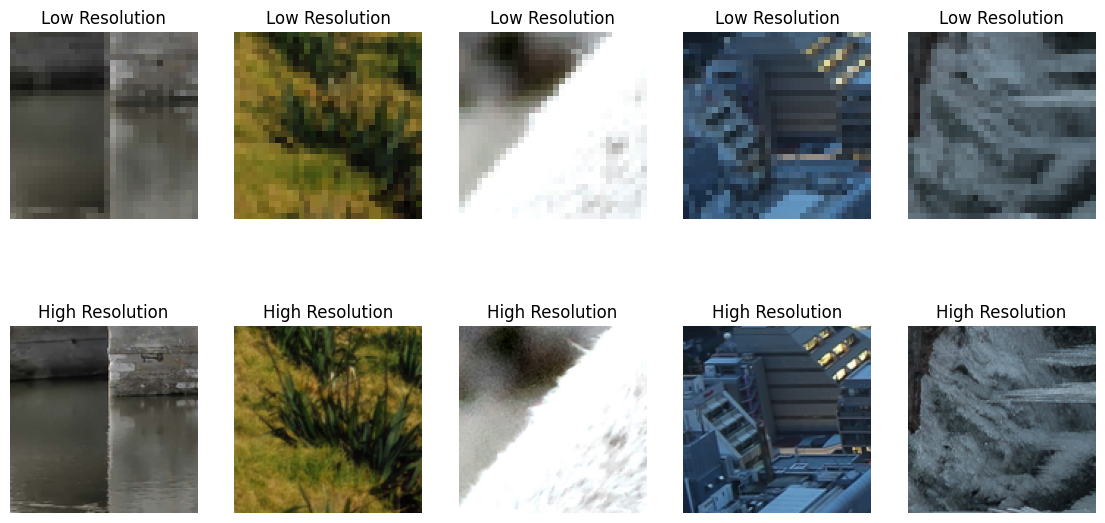

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(14, 7))

for i, (low_res, high_res) in enumerate(val_loader):
    if i >= 5:
        plt.show()
        break

    axes[0, i].imshow(low_res[0].permute(1, 2, 0))
    axes[0, i].set_title("Low Resolution")
    axes[0, i].axis('off')

    axes[1, i].imshow(high_res[0].permute(1, 2, 0))
    axes[1, i].set_title("High Resolution")
    axes[1, i].axis('off')


In [ ]:
generator = Generator(in_channels=num_channels, num_blocks=1).to(device)
discriminator = Discriminator(in_channels=num_channels).to(device)
init_weights(generator)
model = {
    'discriminator': discriminator,
    'generator': generator
}

In [ ]:
optimizer_generator = torch.optim.Adam(model['generator'].parameters(), lr=lr, betas=(0.0, 0.9))
optimizer_discriminator = torch.optim.Adam(model['discriminator'].parameters(), lr=lr, betas=(0.0, 0.9))
optimizer = {
    'discriminator': optimizer_discriminator,
    'generator': optimizer_generator
}


In [ ]:
criterion_generator = ESRGANLoss(l1_weight=1e-2,device=device)
criterion_discriminator = nn.BCELoss().to(device)
criterion = {
    'discriminator': criterion_discriminator,
    'generator': criterion_generator
}

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 77.9MB/s]


In [ ]:
generator_scaler = torch.cuda.amp.GradScaler()
discriminator_scaler = torch.cuda.amp.GradScaler()

<ipython-input-31-944b20ef6194>:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  generator_scaler = torch.cuda.amp.GradScaler()
<ipython-input-31-944b20ef6194>:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  discriminator_scaler = torch.cuda.amp.GradScaler()


In [ ]:
def plot_examples(low_res_folder, gen, device):
    files = os.listdir(low_res_folder)

    gen.eval()
    for file in files:
        image = Image.open("test_images/" + file)
        with torch.no_grad():
            upscaled_img = gen(
                config.test_transform(image=np.asarray(image))["image"]
                .unsqueeze(0)
                .to(device)
            )
        save_image(upscaled_img * 0.5 + 0.5, f"saved/{file}")
    gen.train()

In [ ]:
def train(
    loader,
    disc,
    gen,
    opt_gen,
    opt_disc,
    l1,
    vgg_loss,
    g_scaler,
    d_scaler,
    tb_step,

    num_epochs=10,
    device = 'cpu'
):
    for iteration in range(num_epochs):
        loop = tqdm(loader, leave=True)

        for idx, (low_res, high_res) in enumerate(loop):
            high_res = high_res.to(device)
            low_res = low_res.to(device)

            with torch.cuda.amp.autocast():
                fake = gen(low_res)
                critic_real = disc(high_res)
                critic_fake = disc(fake.detach())
                gp = gradient_penalty(disc, high_res, fake, device=device)
                loss_critic = (
                    -(torch.mean(critic_real) - torch.mean(critic_fake))
                    + lambda_gp * gp
                )

            opt_disc.zero_grad()
            d_scaler.scale(loss_critic).backward()
            d_scaler.step(opt_disc)
            d_scaler.update()

            # Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
            with torch.cuda.amp.autocast():
                l1_loss = 1e-2 * l1(fake, high_res)
                adversarial_loss = 5e-3 * -torch.mean(disc(fake))
                loss_for_vgg = vgg_loss(fake, high_res)
                gen_loss = l1_loss + loss_for_vgg + adversarial_loss

            opt_gen.zero_grad()
            g_scaler.scale(gen_loss).backward()
            g_scaler.step(opt_gen)
            g_scaler.update()
            tb_step += 1

            loop.set_postfix(
                epoch=str(iteration)+"/"+str(num_epochs),
                gp=gp.item(),
                critic=loss_critic.item(),
                l1=l1_loss.item(),
                vgg=loss_for_vgg.item(),
                adversarial=adversarial_loss.item(),
            )

In [ ]:
tb_step = train(
    loader = train_loader,
    disc = model["discriminator"],
    gen = model['generator'],
    opt_gen = optimizer['generator'],
    opt_disc = optimizer['discriminator'],
    l1 = nn.L1Loss(),
    vgg_loss = VGGLoss(device),
    g_scaler = generator_scaler,
    d_scaler = discriminator_scaler,
    tb_step = 0,
    device = device,
    num_epochs =55
)

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-33-5d4531bbc7c4>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
<ipython-input-33-5d4531bbc7c4>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 100/100 [01:00<00:00,  1.65it/s, adversarial=0.027, critic=-7.98, epoch=54/55, gp=0.307, l1=0.000534, vgg=1.43]


  0%|          | 0/100 [00:01<?, ?it/s]


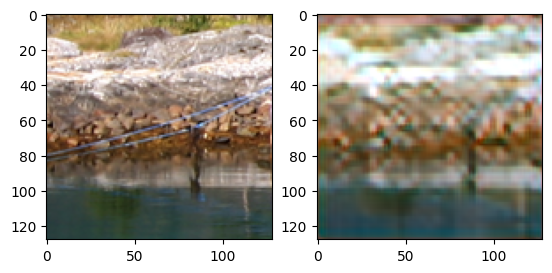

In [ ]:
import matplotlib.pyplot as plt

topil = transforms.ToPILImage()

for iteration, (low_res, high_res) in enumerate(tqdm(val_loader), 0):
    fig, axes = plt.subplots(1, 2)

    axes[0].imshow(high_res[0].permute(1, 2, 0))
    low_res = low_res.to(device)
    fake_high_res = model['generator'](low_res)
    fake_high_res = fake_high_res.to('cpu').detach()
    axes[1].imshow(fake_high_res[0].permute(1, 2, 0))
    break

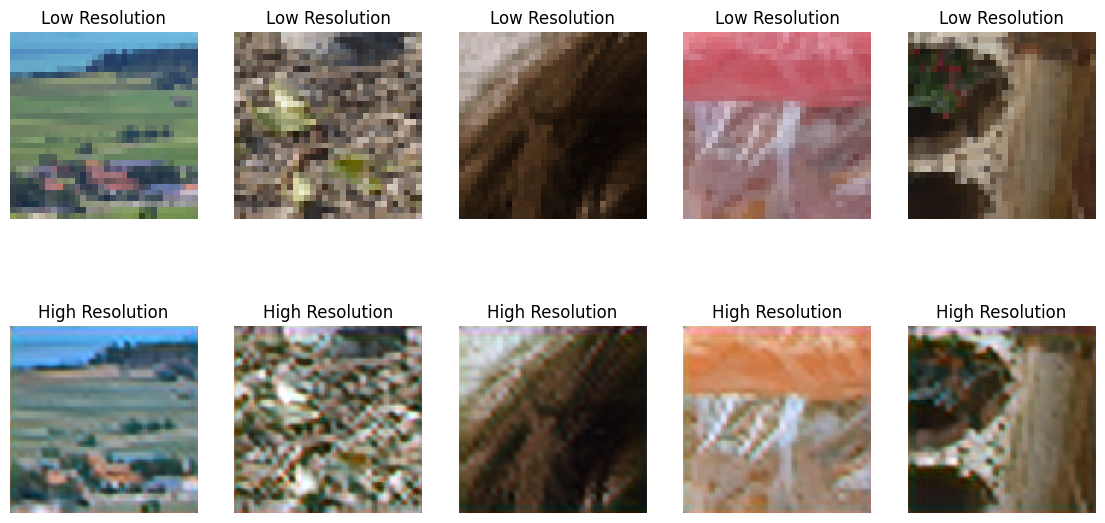

In [ ]:
 fig, axes = plt.subplots(2, 5, figsize=(14, 7))

for i, (low_res, high_res) in enumerate(val_loader):
    if i >= 5:
        plt.show()
        break

    axes[0, i].imshow(low_res[0].permute(1, 2, 0))
    axes[0, i].set_title("Low Resolution")
    axes[0, i].axis('off')

    low_res = low_res.to(device)
    fake_high_res = model['generator'](low_res)
    fake_high_res = fake_high_res.to('cpu').detach()

    axes[1, i].imshow(fake_high_res[0].permute(1, 2, 0))
    axes[1, i].set_title("High Resolution")
    axes[1, i].axis('off')

In [ ]:
# prompt: write code to save the trained model

torch.save(model['generator'].state_dict(), '/content/drive/MyDrive/generator_model.pth')
torch.save(model['discriminator'].state_dict(), '/content/drive/MyDrive/discriminator_model.pth')


In [ ]:
# prompt: generate code to upload image from the user and enhance resolution using thwe above code

from google.colab import files
import io
from PIL import Image
import torchvision.transforms as transforms

def upload_and_enhance():
  uploaded = files.upload()
  for fn in uploaded.keys():
    image = Image.open(io.BytesIO(uploaded[fn]))
    transform = transforms.ToTensor()
    low_res_image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
      enhanced_image = model['generator'](low_res_image)

    enhanced_image = enhanced_image.squeeze(0).cpu().detach()
    to_pil = transforms.ToPILImage()
    enhanced_image_pil = to_pil(enhanced_image)
    enhanced_image_pil.save("enhanced_"+fn)
    files.download("enhanced_"+fn)

upload_and_enhance()


Saving coolcat.jpeg to coolcat.jpeg


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# prompt: how to load saved trained daset from aboe code,

# Load the saved generator model
generator = Generator(in_channels=num_channels, num_blocks=1).to(device)
generator.load_state_dict(torch.load('/content/drive/MyDrive/generator_model.pth'))
generator.eval()  # Set the model to evaluation mode

# Load the saved discriminator model (if needed)
discriminator = Discriminator(in_channels=num_channels).to(device)
discriminator.load_state_dict(torch.load('/content/drive/MyDrive/discriminator_model.pth'))
discriminator.eval()  # Set the model to evaluation mode


# Now you can use the loaded generator and discriminator for inference or further training.
# For example, to generate a super-resolved image from a low-resolution input:
# low_res_image = ... # Your low-resolution image as a PyTorch tensor
# with torch.no_grad():
#   enhanced_image = generator(low_res_image)


In [ ]:
# Install required libraries
!pip install scikit-image scikit-learn seaborn --quiet


In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve


In [ ]:
def evaluate_sr_metrics(sr_image, hr_image, threshold=0.5):
    """
    Evaluate SR output vs HR using binary classification metrics.
    Assumes images are grayscale in [0, 1].
    """
    # Normalize if needed
    if sr_image.max() > 1.0:
        sr_image = sr_image / 255.0
    if hr_image.max() > 1.0:
        hr_image = hr_image / 255.0

    # Binarize
    sr_bin = (sr_image > threshold).astype(int).flatten()
    hr_bin = (hr_image > threshold).astype(int).flatten()

    # Confusion Matrix & Metrics
    cm = confusion_matrix(hr_bin, sr_bin)
    precision = precision_score(hr_bin, sr_bin)
    recall = recall_score(hr_bin, sr_bin)
    f1 = f1_score(hr_bin, sr_bin)

    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    # Heatmap
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Ground Truth")
    plt.show()

    # PR Curve
    precision_vals, recall_vals, _ = precision_recall_curve(hr_bin, sr_image.flatten())
    plt.figure(figsize=(6,4))
    plt.plot(recall_vals, precision_vals, label='PR Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid()
    plt.legend()
    plt.show()


In [ ]:
# Inference loop with evaluation
model['generator'].eval()  # Call eval() on the generator model
model['discriminator'].eval() # Call eval() on the discriminator model

for i, data in enumerate(test_loader):
    lr, hr = data[0].to(device), data[1].to(device)

    with torch.no_grad():
        sr = model['generator'](lr) # Call the generator from the dictionary

# Inference loop with evaluation
model.eval()

for i, data in enumerate(test_loader):
    lr, hr = data[0].to(device), data[1].to(device)

    with torch.no_grad():
        sr = model(lr)

    # Convert to NumPy
    sr_img = sr.squeeze().cpu().numpy().transpose(1, 2, 0)
    hr_img = hr.squeeze().cpu().numpy().transpose(1, 2, 0)

    # Convert RGB to grayscale (mean of channels)
    sr_gray = np.mean(sr_img, axis=2)
    hr_gray = np.mean(hr_img, axis=2)

    # PSNR & SSIM
    psnr = peak_signal_noise_ratio(hr_gray, sr_gray, data_range=1.0)
    ssim = structural_similarity(hr_gray, sr_gray, data_range=1.0)

    print(f"\nImage {i+1}")
    print(f"PSNR: {psnr:.2f} dB")
    print(f"SSIM: {ssim:.4f}")

    # Classification Metrics
    evaluate_sr_metrics(sr_gray, hr_gray)

    # Optional: break early to test one image
    break


NameError: name 'test_loader' is not defined

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Image 1
PSNR: 23.78 dB
SSIM: 0.6080
Precision: 0.8018
Recall:    0.9563
F1 Score:  0.8723


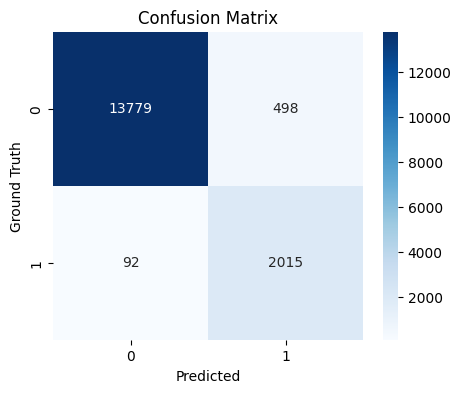

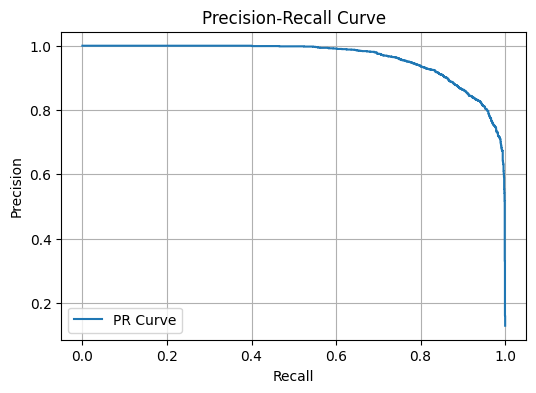

In [ ]:
# Install required libraries
!pip install scikit-image scikit-learn seaborn --quiet

# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve
from torch.utils.data import DataLoader  # Import DataLoader


def evaluate_sr_metrics(sr_image, hr_image, threshold=0.5):
    """
    Evaluate SR output vs HR using binary classification metrics.
    Assumes images are grayscale in [0, 1].
    """
    # Normalize if needed
    if sr_image.max() > 1.0:
        sr_image = sr_image / 255.0
    if hr_image.max() > 1.0:
        hr_image = hr_image / 255.0

    # Binarize
    sr_bin = (sr_image > threshold).astype(int).flatten()
    hr_bin = (hr_image > threshold).astype(int).flatten()

    # Confusion Matrix & Metrics
    cm = confusion_matrix(hr_bin, sr_bin)
    precision = precision_score(hr_bin, sr_bin)
    recall = recall_score(hr_bin, sr_bin)
    f1 = f1_score(hr_bin, sr_bin)

    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    # Heatmap
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Ground Truth")
    plt.show()

    # PR Curve
    precision_vals, recall_vals, _ = precision_recall_curve(hr_bin, sr_image.flatten())
    plt.figure(figsize=(6, 4))
    plt.plot(recall_vals, precision_vals, label='PR Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid()
    plt.legend()
    plt.show()


# Create test_loader (assuming your test dataset is 'val_dataset')
test_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    pin_memory=True,
    num_workers=num_workers
)

# Inference loop with evaluation
model['generator'].eval()  # Set the generator to evaluation mode
model['discriminator'].eval()  # Set the discriminator to evaluation mode

for i, data in enumerate(test_loader):
    lr, hr = data[0].to(device), data[1].to(device)

    with torch.no_grad():
        sr = model['generator'](lr)  # Pass the low-resolution image to the generator

    # Convert to NumPy for metric calculations
    sr_img = sr.squeeze().cpu().numpy().transpose(1, 2, 0)
    hr_img = hr.squeeze().cpu().numpy().transpose(1, 2, 0)

    # Convert RGB to grayscale (mean of channels)
    sr_gray = np.mean(sr_img, axis=2)
    hr_gray = np.mean(hr_img, axis=2)

    # Calculate PSNR and SSIM
    psnr = peak_signal_noise_ratio(hr_gray, sr_gray, data_range=1.0)
    ssim = structural_similarity(hr_gray, sr_gray, data_range=1.0)

    # Print the results
    print(f"\nImage {i+1}")
    print(f"PSNR: {psnr:.2f} dB")
    print(f"SSIM: {ssim:.4f}")

    # Evaluate using classification metrics
    evaluate_sr_metrics(sr_gray, hr_gray)

    # Optional: break early to test one image
    break

In [ ]:
# Install required libraries
!pip install scikit-image scikit-learn seaborn --quiet

# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc
from torch.utils.data import DataLoader  # Import DataLoader


def evaluate_sr_metrics(sr_image, hr_image, threshold=0.5):
    """
    Evaluate SR output vs HR using binary classification metrics.
    Assumes images are grayscale in [0, 1].
    """
    # ... (Your existing evaluate_sr_metrics function) ...

    # Additional Metrics and Visualizations:

    # ROC Curve and AUC
    fpr, tpr, _ = roc_curve(hr_bin, sr_image.flatten())
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    # Histogram of Pixel Differences
    diff = sr_image - hr_image
    plt.figure(figsize=(6, 4))
    plt.hist(diff.flatten(), bins=50)
    plt.title('Histogram of Pixel Differences (SR - HR)')
    plt.xlabel('Pixel Difference')
    plt.ylabel('Frequency')
    plt.show()


# Create test_loader (assuming your test dataset is 'val_dataset')
test_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    pin_memory=True,
    num_workers=num_workers
)
